In [22]:
# %%
##############################################################
############### Examining average performance across experimental connditionns. MD ablation, vmPFC ablation and with and without OFC
##############################################################
import matplotlib as mpl
import matplotlib
mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = True

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os, re, sys
import pickle
import glob
import itertools
from tqdm import tqdm
sys.path.append('./../')
file_format= 'JPG'



In [23]:
exp_name = 'dynamic_eligibility_trace/HebbianLearning'
results_folder = './../results/'
config_files = glob.glob(results_folder  + exp_name + "/" + "config*")
log_files = glob.glob(results_folder  + exp_name + "/" + "log*")

var1s   = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
var1s   = [ 10, 50, 100, 200, 300,  400, 500, 600]

var2s   = [0.02, 0.08, .10, .12,.2, ]
task_vars = list(itertools.product(var1s, var2s)) #810 length

# for var1, var2 in task_vars:

            

variable_values = var1s

no_of_values = len(variable_values)
norm = mpl.colors.Normalize(vmin=min([1,no_of_values]), vmax=max([1,no_of_values]))
cmap_obj = matplotlib.cm.get_cmap('viridis')
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)


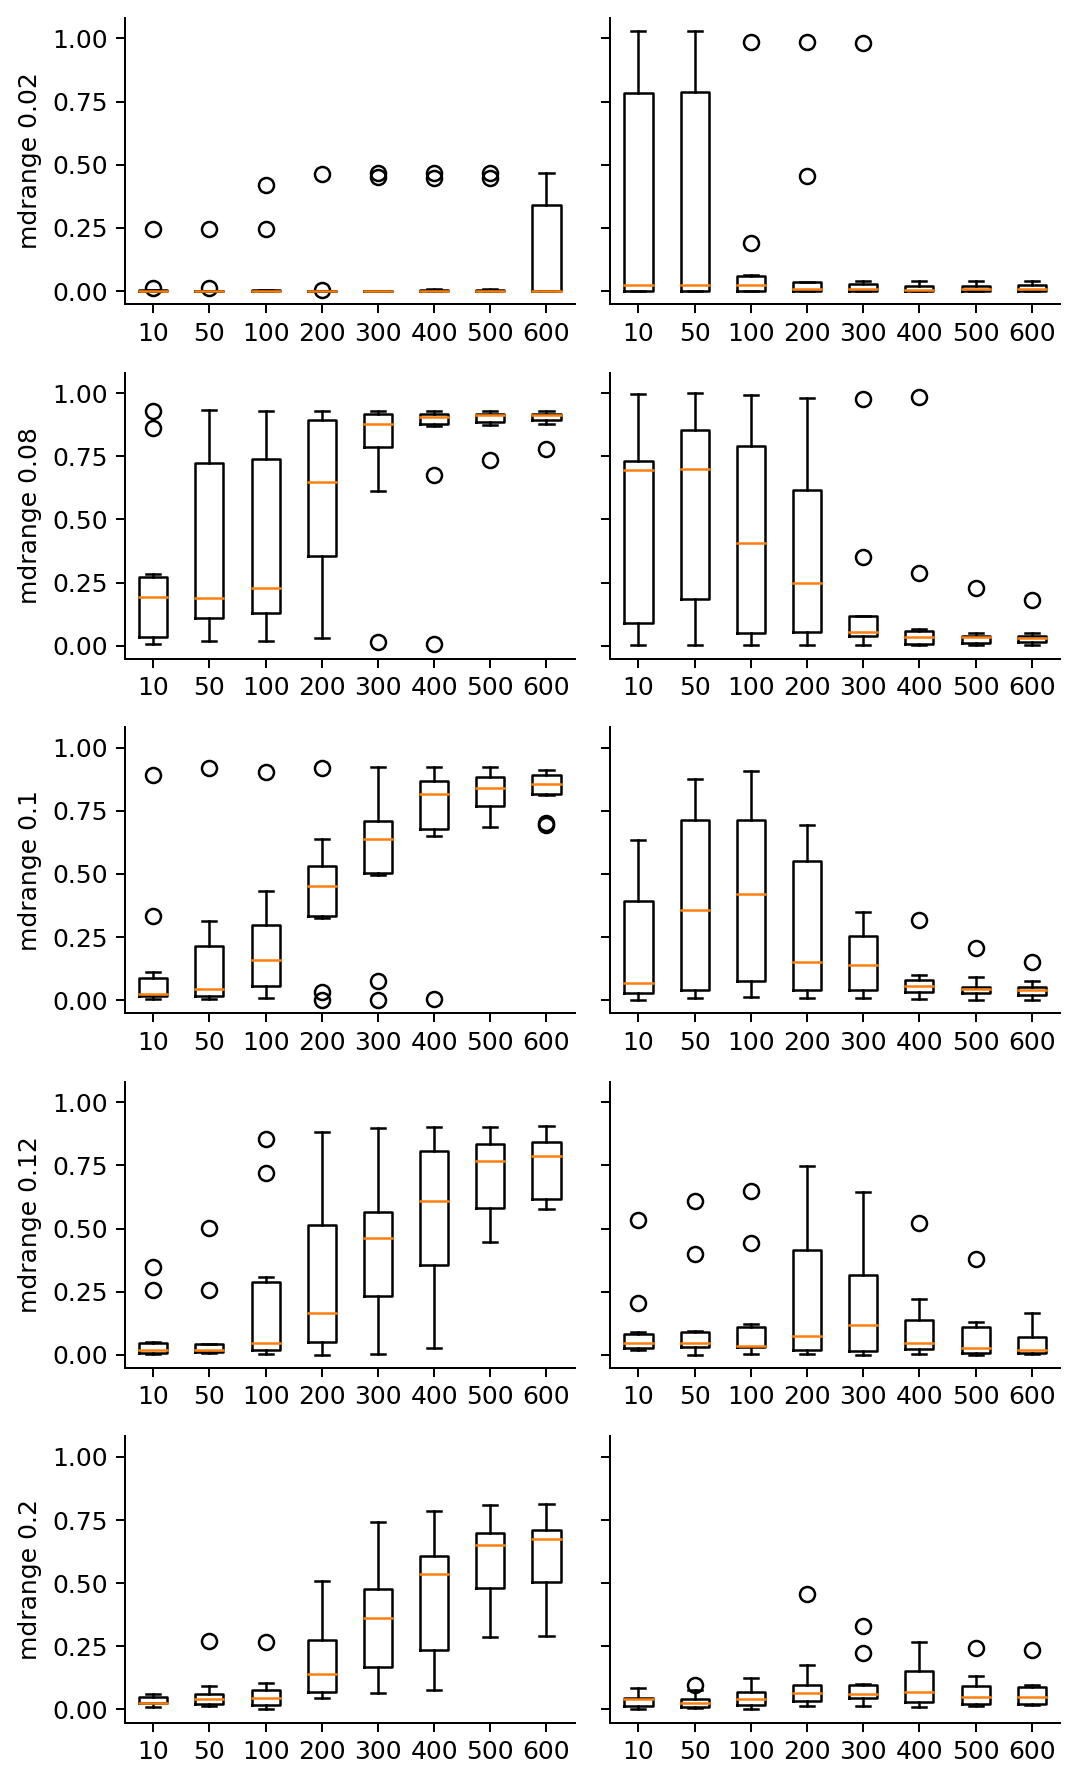

In [24]:

def get_md_modulations(var2_to_run):
    vars = [(var1, var2) for var1 in var1s for var2 in [var2_to_run]]
    # regexes = [f"\d_{float(var1):1.0f}_{float(var2):1.0f}_1.0" if var2%1==0 else f"\d_{float(var1):1.0f}_{float(var2):1.1f}_1.0" for var1, var2 in vars ]  
    regexes = [f"\d_{float(var1):1.0f}_{float(var2):1.1f}_4.0" if var2%0.1==0 else f"\d_{float(var1):1.0f}_{float(var2):1.2f}_4.0" for var1, var2 in vars ]  
    labels = [f"{var1} {var2}" for var1, var2  in vars]

    means, stds, md_cmodulations, md_smodulations = [], [], [], []
    means_all = [] # means pooled the other axis, pooling all trials for each run.
    for i, (label, regex) in enumerate(zip(labels, regexes)):
        comp_files =  [file for file in log_files if re.search(regex, file)]
        conf_files =   [file for file in config_files if re.search(regex, file)]
        if len(comp_files) > 0:
            # print('++++++++++++++++++++++++++++++\n',comp_files)
            performances, cmods, smods =[], [], []
            for log_file, config_file in zip (comp_files, conf_files):
                log = np.load(log_file, allow_pickle=True).item()
                config = np.load(config_file, allow_pickle=True).item()
                # if log.md_context_modulation > 0.8 : 
                performances.append(log.corrects)
                cmods.append(log.md_context_modulation)

                cue_vector = np.ones(np.sum(config.variable_trials_per_block))
                cue_vector[log.Inputs[:,1] == 1] = -1
                log.md_cue_modulation = np.abs( np.dot(cue_vector, log.MDrates.mean(1)[:,0]/np.sum(cue_vector>0)))

                smods.append(log.md_cue_modulation)
            # smooth_performances = [np.convolve(performance, np.ones((40,))/40, mode='valid') for performance in performances]
            # sp = np.stack(smooth_performances)
            # spmean = np.mean(sp, axis=0)    
            # spstd = np.std(sp, axis=0)    
            # means.append(spmean)
            # means_all.append(sp.mean(1))
            # stds.append(spstd)
            md_cmodulations.append(cmods)
            md_smodulations.append(smods)
        else:
            print(f'no files found for {label}  regex {regex}')
    return (md_cmodulations, md_smodulations, labels)


fig, axes = plt.subplots(len(var2s),2 , figsize=[6, len(var2s)*2], sharey=True)
for i in range(len(var2s)):
    md_cmodulations, md_smodulations, labels = get_md_modulations(var2s[i])
    ax = axes[i,0]
    _=ax.boxplot(md_cmodulations)
    _=ax.set_xticklabels(var1s)
    ax.set_ylabel(f'mdrange {var2s[i]}')
    ax = axes[i,1]
    _=ax.boxplot(md_smodulations)
    _=ax.set_xticklabels(var1s)
fig.tight_layout()

In [3]:
detailed_log = np.load('./../results/dynamic_eligibility_trace/HebbianLearning/log_0_2000_0.1_4__01-09_23:30.npy' , allow_pickle=True).item()

In [6]:
srt = np.argsort(detailed_log.MDpreTraces[:500, :].mean(0))

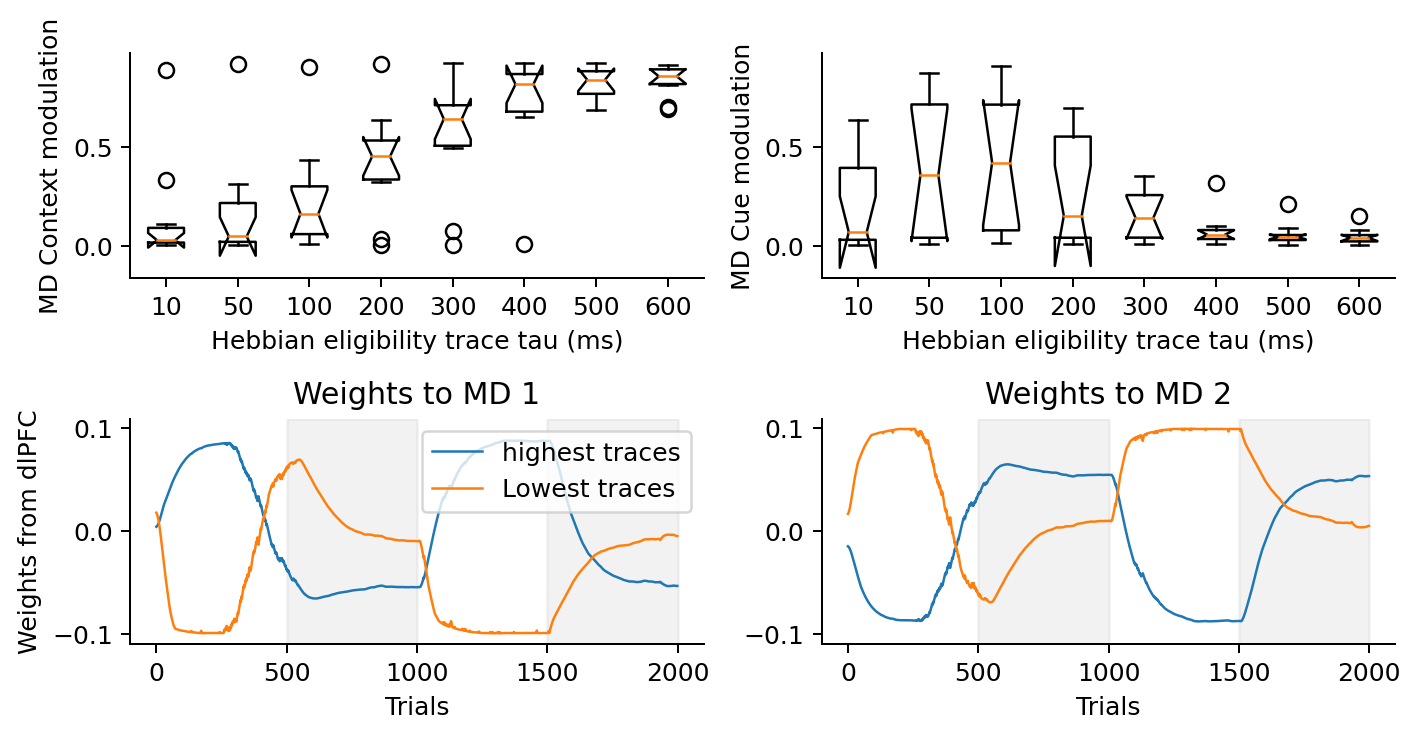

In [31]:
fig, axes = plt.subplots(2,2 , figsize=[8, 4], sharey=False)
md_cmodulations, md_smodulations, labels = get_md_modulations(0.1)
ax = axes[0,0]
_=ax.boxplot(md_cmodulations, notch=True)
_=ax.set_xticklabels(var1s)
ax.set_ylabel('MD Context modulation')
ax.set_xlabel('Hebbian eligibility trace tau (ms)')

ax = axes[0,1]
_=ax.boxplot(md_smodulations, notch=True)
_=ax.set_xticklabels(var1s)
ax.set_ylabel('MD Cue modulation')
ax.set_xlabel('Hebbian eligibility trace tau (ms)')

ax = axes[1,0]
# _=ax.plot(detailed_log.wPFC2MDs[:, 0, srt[:5]] , linewidth=0.5 ) # (2000, 2, 500)
_=ax.plot(detailed_log.wPFC2MDs[:, 0, srt[:5]].mean(1), linewidth=1 , label='highest traces') # (2000, 2, 500)
_=ax.plot(detailed_log.wPFC2MDs[:, 0, srt[-5:]].mean(1), linewidth=1 , label='Lowest traces') # (2000, 2, 500)
ax.set_ylabel('Weights from dlPFC')
ax.set_title('Weights to MD 1')
ax.set_xlabel('Trials')
ax.legend()
tpb= 500
for ib in range(1, 4,2):
            ax.axvspan(tpb* ib, tpb*(ib+1), alpha=0.1, color='grey')
ax = axes[1,1]
# _=ax.plot(detailed_log.wPFC2MDs[:, 1, srt[:5]] ) # (2000, 2, 500)
_=ax.plot(detailed_log.wPFC2MDs[:, 1, srt[:5]].mean(1), linewidth=1 ) # (2000, 2, 500)
_=ax.plot(detailed_log.wPFC2MDs[:, 1, srt[-5:]].mean(1), linewidth=1 ) # (2000, 2, 500)
# ax.set_ylabel('Weights from dlPFC')
ax.set_title('Weights to MD 2')
ax.set_xlabel('Trials')
for ib in range(1, 4,2):
            ax.axvspan(tpb* ib, tpb*(ib+1), alpha=0.1, color='grey')

for i in range(2):
    axes[i,0].get_shared_y_axes().join(axes[i,0], axes[i,1])

fig.tight_layout()
# plt.savefig('./exports/Figure_Hebbian.PDF', dpi=300)

In [4]:
# save and load for efficiency
if not load_saved_data:
    np.save('./data/means.npy', means)
    np.save('./data/means_2.npy', means_2)
    np.save('./data/means_all.npy', means_all)
    np.save('./data/means_all_2.npy', means_all_2)
    np.save ('./data/labels.npy', labels)

if load_saved_data:
    means = np.load('./data/means.npy', allow_pickle=True)
    means_2= np.load('./data/means_2.npy', allow_pickle=True)
    means_all = np.load('./data/means_all.npy', allow_pickle=True)
    means_all_2 = np.load('./data/means_all_2.npy',allow_pickle=True)
    labels = np.load ('./data/labels.npy', allow_pickle=True)


In [7]:
exp_name = 'add_vs_mul_data/MD_ablation'
results_folder = './../results/'
#get files
files = os.listdir( results_folder  + exp_name+'/')
config_files = [file for file in files if 'config' in file]
log_files = [file for file in files if 'log' in file]
exps = {0: 'MD intact', 1: 'Add gates', 2:'Mul gates', 3:'MD lesioned'}
# variable_values = [1,  1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 10, 15, 20, 25, 30]

def get_correlations(exp_to_run):
    vars = [(var1, var2) for var1 in [exp_to_run] for var2 in variable_values]
    regexes = [f"\d_{float(var1):1.1f}_{float(var2):1.1f}_1.0" for var1, var2 in vars]  
    labels = [f"{exps[var1]} {var2}" for var1, var2  in vars]

    m_nm_corrs, up_dn_corrs = [], []
    for i, (label, regex) in enumerate(zip (labels, regexes)):
        comp_files =  [os.path.join(file) for file in log_files if re.search(regex, file)]
        conf_files =  [os.path.join(file) for file in config_files if re.search(regex, file)]
        
        if len(comp_files) > 0:
            m_nm_corr, up_dn_corr = [], []
            for ii, (log_file, config_file) in enumerate(zip(comp_files, conf_files)):
                log = np.load(results_folder+exp_name+'/' +log_file, allow_pickle=True).item()
                config = np.load(results_folder+exp_name+'/' +config_file, allow_pickle=True).item()
                # find left vs right trials
                # calucalte corr using a few methods
                # up trials
                inputs = np.stack(log.Inputs)
                # idx_dn_m = np.argwhere(log.MDrates.mean(1)[:,1] * (inputs[:,0] == 0.))
                # idx_up_m = np.argwhere(log.MDrates.mean(1)[:,1] * (inputs[:,0] == 1.))
                # idx_up_nm = np.argwhere(log.MDrates.mean(1)[:,0] * (inputs[:,0] == 1.))
                # idx_dn_nm = np.argwhere(log.MDrates.mean(1)[:,0] * (inputs[:,0] == 0.))

                idx_up = np.argwhere((inputs[:,0] == 1.))
                idx_dn = np.argwhere((inputs[:,0] == 0.))

                #find m vs nm trials
                idx_m = np.argwhere(log.MDrates.mean(1)[:,1]) 
                idx_nm = np.argwhere(log.MDrates.mean(1)[:,0]) 

                trials_min = min( len(idx_up), len(idx_dn) )
                up_sig = log.PFCrates[idx_up[:trials_min], :, :].mean(2)
                dn_sig = log.PFCrates[idx_dn[:trials_min], :, :].mean(2)
                up_dn_corr.append(np.corrcoef(up_sig.reshape(-1), dn_sig.reshape(-1))[0,1])

                trials_min = min( len(idx_m), len(idx_nm) )
                m_sig = log.PFCrates[idx_m[:trials_min], :, :].mean(2)
                nm_sig = log.PFCrates[idx_nm[:trials_min], :, :].mean(2)
                m_nm_corr.append(np.corrcoef(m_sig.reshape(-1), nm_sig.reshape(-1))[0,1])
            m_nm_corrs.append(m_nm_corr)
            up_dn_corrs.append(up_dn_corr)
    return (m_nm_corrs, up_dn_corrs)


In [8]:

m_nm_corrs, up_dn_corrs = get_correlations(1)
m_nm_corrs2, up_dn_corrs2 = get_correlations(2)



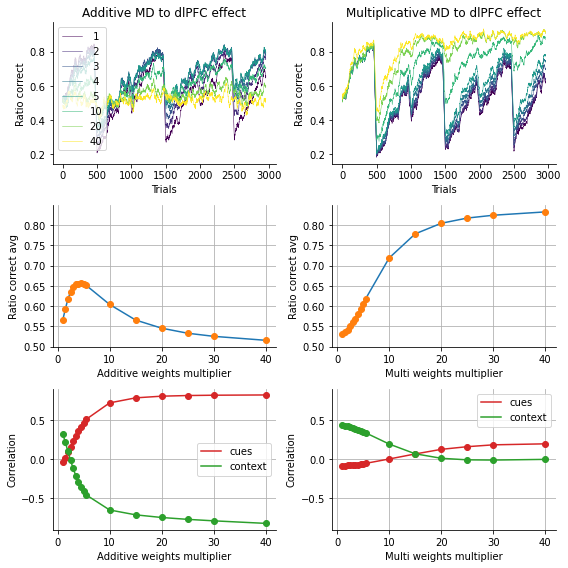

In [9]:

fig, axes = plt.subplots(3, 2, figsize=[8,8])

ax = axes[0,0]
for i, (spmean, label) in enumerate(zip(means,labels)):
    if i in [0,2,4,6, 8, 10, 12, 15]:
        ax.plot(range(len(spmean)), spmean, label=label[-2:], linewidth=0.5, color=cmap.to_rgba(i+1),)
ax.legend()
ax.set_xlabel('Trials')
ax.set_ylabel('Ratio correct')
ax.set_title('Additive MD to dlPFC effect')

ax = axes[0,1]
for i, (spmean, label) in enumerate(zip(means_2,labels)):
    if i in [0,2, 4, 6,8, 10, 12,  15]:
        ax.plot(range(len(spmean)), spmean, label=label[-2:], linewidth=0.5, color=cmap.to_rgba(i+1),)
ax.set_xlabel('Trials')
ax.set_ylabel('Ratio correct')
ax.set_title('Multiplicative MD to dlPFC effect')
# ax.legend()

ax = axes[1,0]
ax.plot(variable_values, [m.mean() for m in means])
ax.plot(variable_values, [m.mean() for m in means], 'o')
ax.set_ylabel('Ratio correct avg')
ax.set_xlabel('Additive weights multiplier')
ax.grid()

ax = axes[1,1]
ax.plot(variable_values, [m.mean() for m in means_2])
ax.plot(variable_values, [m.mean() for m in means_2], 'o')
ax.set_ylabel('Ratio correct avg')
ax.set_xlabel('Multi weights multiplier')
ax.grid()

## Correlations
color_one, color_two = 'tab:red', 'tab:green'
ax = axes[2,0]
ax.plot(variable_values, [np.mean(m) for m in up_dn_corrs], label= 'cues', color=color_one)
ax.plot(variable_values, [np.mean(m) for m in up_dn_corrs], 'o', color=color_one)
ax.plot(variable_values, [np.mean(m) for m in m_nm_corrs], label= 'context', color=color_two)
ax.plot(variable_values, [np.mean(m) for m in m_nm_corrs], 'o', color=color_two)
ax.set_ylabel('Correlation')
ax.set_xlabel('Additive weights multiplier')
ax.grid()
ax.legend()

ax = axes[2,1]
ax.plot(variable_values, [np.mean(m) for m in up_dn_corrs2], label= 'cues', color=color_one)
ax.plot(variable_values, [np.mean(m) for m in up_dn_corrs2], 'o', color=color_one)
ax.plot(variable_values, [np.mean(m) for m in m_nm_corrs2], label= 'context', color=color_two)
ax.plot(variable_values, [np.mean(m) for m in m_nm_corrs2], 'o', color=color_two)
ax.grid()
ax.set_ylabel('Correlation')
ax.set_xlabel('Multi weights multiplier')
ax.legend()
for i in range(3):
    axes[i,0].get_shared_y_axes().join(axes[i,0], axes[i,1])
fig.tight_layout()
# plt.savefig('./exports/mul_vs_add_detailed.jpg', dpi=300)

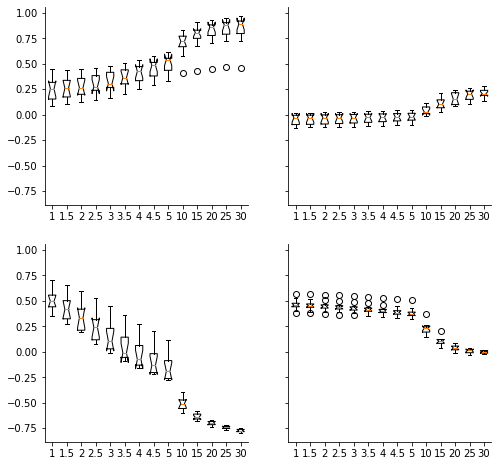

In [12]:

# _=ax.boxplot(up_dn_corrs, notch=True)
# _=ax.set_xticklabels(variable_values)
# ax = axes[1,0]
# _=ax.boxplot(m_nm_corrs, notch=True)
# _=ax.set_xticklabels(variable_values)

fig, axes = plt.subplots(2,2 , figsize=[8,8], sharey=True)

ax = axes[0,0]

plt.plot(variable_values, [m.mean() for m in up_dn_corrs])
plt.plot(variable_values, [m.mean() for m in up_dn_corrs], 'o')
plt.plot(variable_values, [m.mean() for m in m_nm_corrs])
plt.plot(variable_values, [m.mean() for m in m_nm_corrs], 'o')

plt.gca().set_ylabel('avg ratio correct')
plt.gca().grid()



ax = axes[0,1]
_=ax.boxplot(up_dn_corrs, notch=True)
_=ax.set_xticklabels(variable_values)
ax = axes[1,1]
_=ax.boxplot(m_nm_corrs, notch=True)
_=ax.set_xticklabels(variable_values)
plt.savefig('./exports/corr_up_dn.jpg', dpi=300)
